## Imports and File Loads

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import folium
from folium import plugins

`y_pred_rfr` are the predicted values from the RandomForestRegressor.

In [2]:
y_pred_rfr = pd.read_csv('../models/y_pred_rfr.csv', index_col=0)
y_pred_rfr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 0 to 115
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       116 non-null    float64
dtypes: float64(1)
memory usage: 1.8 KB


In [3]:
y_pred_rfr.shape

(116, 1)

`test_df` contains the true values.

In [4]:
test_df = pd.read_pickle('../data/processed/3-0_test_df.pkl')
test_df.shape

(116, 60)

`county_df` contains some fire information per county and a bit of other county information.

In [5]:
county_df = pd.read_pickle('../data/interim/2-1_county_df.pkl')

`old_fires` has information on the total number of acres burned in California in 1987-2018.

In [6]:
old_fires = pd.read_csv('../data/raw/OldFires.csv')
old_fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Year       32 non-null     int64
 1   Incidents  32 non-null     int64
 2   Acres      32 non-null     int64
dtypes: int64(3)
memory usage: 896.0 bytes


`geojson` is the GeoJSON from [opendatasoft](https://public.opendatasoft.com/explore/dataset/georef-united-states-of-america-county/export/?disjunctive.ste_code&disjunctive.ste_name&disjunctive.coty_code&disjunctive.coty_name&sort=year); it  contains information about counties. Specifically, we will use the border polygons, stored in `geometry`.

In [7]:
geojson = geopandas.read_file(r'../data/raw/georef-united-states-of-america-county_CA.geojson')
geojson.shape

(58, 12)

In [8]:
geojson.columns

Index(['geo_point_2d', 'year', 'ste_code', 'ste_name', 'coty_code',
       'coty_name', 'coty_area_code', 'coty_type', 'coty_name_long',
       'coty_fp_code', 'coty_gnis_code', 'geometry'],
      dtype='object')

In [9]:
geojson.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   geo_point_2d    58 non-null     object  
 1   year            58 non-null     object  
 2   ste_code        58 non-null     object  
 3   ste_name        58 non-null     object  
 4   coty_code       58 non-null     object  
 5   coty_name       58 non-null     object  
 6   coty_area_code  58 non-null     object  
 7   coty_type       58 non-null     object  
 8   coty_name_long  58 non-null     object  
 9   coty_fp_code    58 non-null     object  
 10  coty_gnis_code  58 non-null     object  
 11  geometry        58 non-null     geometry
dtypes: geometry(1), object(11)
memory usage: 5.6+ KB


In [10]:
# California's state code is 06
indices = []
for i in geojson.index:
    if (geojson.loc[i]['ste_name'][0] == 'California'):
        indices.append(i)
len(indices)

58

In [11]:
ca_geojson = geojson.iloc[indices]

In [12]:
ca_geojson.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 58 entries, 0 to 57
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   geo_point_2d    58 non-null     object  
 1   year            58 non-null     object  
 2   ste_code        58 non-null     object  
 3   ste_name        58 non-null     object  
 4   coty_code       58 non-null     object  
 5   coty_name       58 non-null     object  
 6   coty_area_code  58 non-null     object  
 7   coty_type       58 non-null     object  
 8   coty_name_long  58 non-null     object  
 9   coty_fp_code    58 non-null     object  
 10  coty_gnis_code  58 non-null     object  
 11  geometry        58 non-null     geometry
dtypes: geometry(1), object(11)
memory usage: 5.9+ KB


In [13]:
ca_geojson.head(3)

geo_point_2d  year ste_code  \
0  {'lon': -121.34425549901626, 'lat': 38.4493218...  2022     [06]   
1  {'lon': -121.9399898298617, 'lat': 38.26692145...  2022     [06]   
2  {'lon': -123.91581947074941, 'lat': 40.7050091...  2022     [06]   

       ste_name coty_code     coty_name coty_area_code coty_type  \
0  [California]   [06067]  [Sacramento]            USA    county   
1  [California]   [06095]      [Solano]            USA    county   
2  [California]   [06023]    [Humboldt]            USA    county   

        coty_name_long coty_fp_code coty_gnis_code  \
0  [Sacramento County]          067       00277298   
1      [Solano County]          095       00277312   
2    [Humboldt County]          023       01681908   

                                            geometry  
0  POLYGON ((-121.58002 38.09441, -121.57893 38.0...  
1  POLYGON ((-121.59327 38.31309, -121.59456 38.3...  
2  POLYGON ((-123.40829 41.17994, -123.40893 41.1...

A lot of these values are in lists...

In [14]:
county_list = []
for i in range(len(ca_geojson)):
    county_list.append(ca_geojson.iloc[i]['coty_name'][0])
len(county_list)

58

In [15]:
ca_geojson['County'] = pd.Series(county_list)

In [16]:
ca_geojson['County'] = county_list

In [17]:
ca_geojson.head(3)

geo_point_2d  year ste_code  \
0  {'lon': -121.34425549901626, 'lat': 38.4493218...  2022     [06]   
1  {'lon': -121.9399898298617, 'lat': 38.26692145...  2022     [06]   
2  {'lon': -123.91581947074941, 'lat': 40.7050091...  2022     [06]   

       ste_name coty_code     coty_name coty_area_code coty_type  \
0  [California]   [06067]  [Sacramento]            USA    county   
1  [California]   [06095]      [Solano]            USA    county   
2  [California]   [06023]    [Humboldt]            USA    county   

        coty_name_long coty_fp_code coty_gnis_code  \
0  [Sacramento County]          067       00277298   
1      [Solano County]          095       00277312   
2    [Humboldt County]          023       01681908   

                                            geometry      County  
0  POLYGON ((-121.58002 38.09441, -121.57893 38.0...  Sacramento  
1  POLYGON ((-121.59327 38.31309, -121.59456 38.3...      Solano  
2  POLYGON ((-123.40829 41.17994, -123.40893 41.1...    Humboldt

Selecting only the fields we need. `County` so that we can merge it with our DataFrames, `geometry` so we have boundaries for each county, and `coty_fp_code` which is the county's FP code (unique at least within California).

In [18]:
ca_geojson_sub = ca_geojson[['County', 'geometry','coty_fp_code']]

In [19]:
ca_geojson_sub.head()

County                                           geometry coty_fp_code
0  Sacramento  POLYGON ((-121.58002 38.09441, -121.57893 38.0...          067
1      Solano  POLYGON ((-121.59327 38.31309, -121.59456 38.3...          095
2    Humboldt  POLYGON ((-123.40829 41.17994, -123.40893 41.1...          023
3    Mariposa  POLYGON ((-119.30899 37.77799, -119.30915 37.7...          043
4   El Dorado  POLYGON ((-121.02751 38.50829, -121.02738 38.5...          017

## Graphing Old Fires

In [20]:
old_fires.head(3)

Year  Incidents   Acres
0  1987      13476  873000
1  1988      13290  345000
2  1989      10024  173400

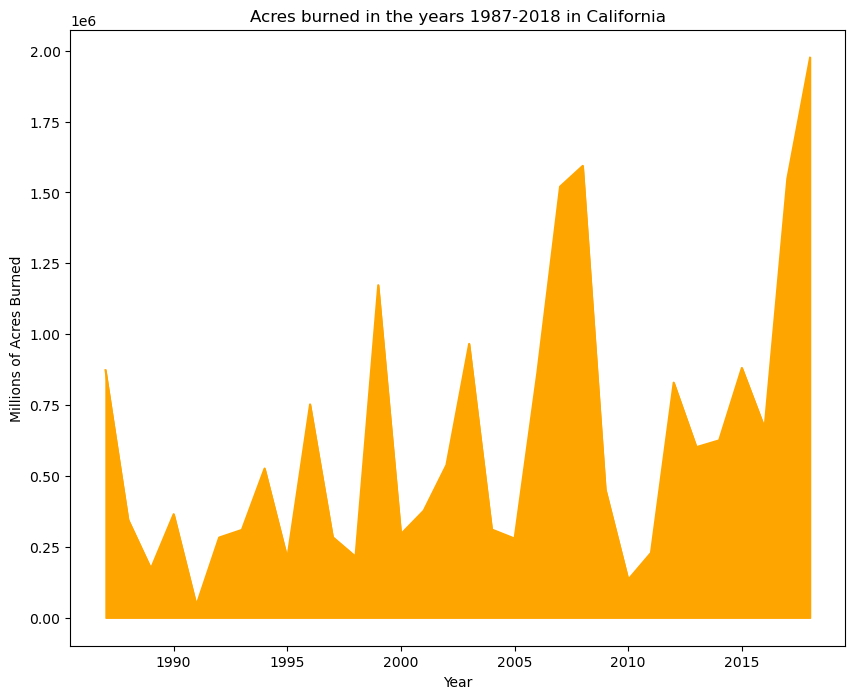

In [21]:
fig, ax = plt.subplots(figsize=[10,8])
ax.plot(old_fires['Year'], old_fires['Acres'], color='orange')
ax.fill_between(old_fires['Year'], old_fires['Acres'], color='orange')

ax.set_title("Acres burned in the years 1987-2018 in California")
ax.set_xlabel("Year")
ax.set_ylabel("Millions of Acres Burned")

plt.show()

In [22]:
# Predicted and true fires, but this idea is scrapped because it lacks clarity and isn't a good way to illustrate
#g = sns.relplot(x=test_df.reset_index().index, y=test_df['NumFires'], kind='scatter', height=5, aspect=1.5)
#_ = plt.plot(y_pred_rfr.index, y_pred_rfr['0'], color='orange')

#g.fig.suptitle("True and predicted number of fires for different counties in 2018-2019")
#g.set_ylabels("Number of fires")

#plt.show()

## Area and Fire Regression Line

In [23]:
county_df_nona = county_df.dropna()
county_df_nona.shape

(56, 11)

In [24]:
X_area = county_df_nona[['Area_sqmi']]
y_fs = county_df_nona[['FireStartCounts']]
X_area.shape, y_fs.shape

((56, 1), (56, 1))

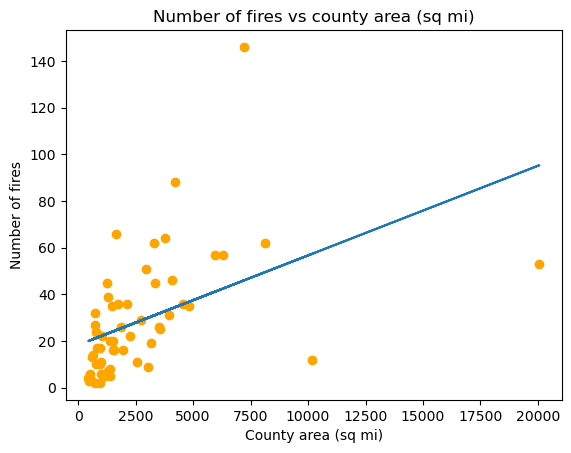

In [25]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_area, y_fs)
lr_pred = lr.predict(X_area)
plt.scatter(X_area, y_fs, color='orange')
plt.plot(X_area, lr_pred)
plt.xlabel("County area (sq mi)")
plt.ylabel("Number of fires")
plt.title("Number of fires vs county area (sq mi)")
plt.show()

## Map

Help followed from [here](https://towardsdatascience.com/folium-and-choropleth-map-from-zero-to-pro-6127f9e68564).

First, the dummy values are reverted to categories.

In [26]:
y_pred_rfr.head(3)

0
0  2.940370
1  2.940370
2  0.436102

In [27]:
#test_df.info()

In [28]:
test_df.iloc[:,3:]

DM_Alpine  DM_Amador  DM_Butte  DM_Calaveras  DM_Colusa  DM_Contra Costa  \
5            0          0         0             0          0                0   
6            0          0         0             0          0                0   
12           1          0         0             0          0                0   
13           1          0         0             0          0                0   
19           0          1         0             0          0                0   
..         ...        ...       ...           ...        ...              ...   
391          0          0         0             0          0                0   
397          0          0         0             0          0                0   
398          0          0         0             0          0                0   
404          0          0         0             0          0                0   
405          0          0         0             0          0                0   

     DM_Del Norte  DM_El Dorado  DM_Fresno  DM_Glenn  ...  DM_Sonoma  \
5               0             0          0         0  ...          0   
6               0             0          0         0  ...          0   
12              0             0          0         0  ...          0   
13              0             0          0         0  ...          0   
19              0             0          0         0  ...          0   
..            ...           ...        ...       ...  ...        ...   
391             0             0          0         0  ...          0   
397             0             0          0         0  ...          0   
398             0             0          0         0  ...          0   
404             0             0          0         0  ...          0   
405             0             0          0         0  ...          0   

     DM_Stanislaus  DM_Sutter  DM_Tehama  DM_Trinity  DM_Tulare  DM_Tuolumne  \
5                0          0          0           0          0            0   
6                0          0          0           0          0            0   
12               0          0          0           0          0            0   
13               0          0          0           0          0            0   
19               0          0          0           0          0            0   
..             ...        ...        ...         ...        ...          ...   
391              0          0          0           0          0            0   
397              0          0          0           0          0            0   
398              0          0          0           0          0            0   
404              0          0          0           0          0            0   
405              0          0          0           0          0            0   

     DM_Ventura  DM_Yolo  DM_Yuba  
5             0        0        0  
6             0        0        0  
12            0        0        0  
13            0        0        0  
19            0        0        0  
..          ...      ...      ...  
391           0        0        1  
397           0        0        0  
398           0        0        0  
404           0        0        0  
405           0        0        0  

[116 rows x 57 columns]

In [29]:
fd_counties = pd.from_dummies(test_df.iloc[:,3:], sep='_', default_category='Alameda')['DM']
#fd_counties.value_counts()

In [30]:
fd_counties.info()

<class 'pandas.core.series.Series'>
RangeIndex: 116 entries, 0 to 115
Series name: DM
Non-Null Count  Dtype 
--------------  ----- 
116 non-null    object
dtypes: object(1)
memory usage: 1.0+ KB


In [31]:
pd.DataFrame(fd_counties)

DM
0          Alameda
1          Alameda
2           Alpine
3           Alpine
4           Amador
..             ...
111           Yuba
112  San Francisco
113  San Francisco
114       Imperial
115       Imperial

[116 rows x 1 columns]

In [32]:
test_df.iloc[:,:3]

StartedYear  NumFires  Area_sqmi
5           2018         8        738
6           2019         9        738
12          2018         0        739
13          2019         0        739
19          2018         2        606
..           ...       ...        ...
391         2019         4        630
397         2018         0         47
398         2019         0         47
404         2018         0       4175
405         2019         0       4175

[116 rows x 3 columns]

In [33]:
test_df_copy = test_df.copy().reset_index()
test_df_copy.shape

(116, 61)

In [34]:
test_df_copy['County'] = fd_counties
test_df_copy.head(3)

index  StartedYear  NumFires  Area_sqmi  DM_Alpine  DM_Amador  DM_Butte  \
0      5         2018         8        738          0          0         0   
1      6         2019         9        738          0          0         0   
2     12         2018         0        739          1          0         0   

   DM_Calaveras  DM_Colusa  DM_Contra Costa  ...  DM_Stanislaus  DM_Sutter  \
0             0          0                0  ...              0          0   
1             0          0                0  ...              0          0   
2             0          0                0  ...              0          0   

   DM_Tehama  DM_Trinity  DM_Tulare  DM_Tuolumne  DM_Ventura  DM_Yolo  \
0          0           0          0            0           0        0   
1          0           0          0            0           0        0   
2          0           0          0            0           0        0   

   DM_Yuba   County  
0        0  Alameda  
1        0  Alameda  
2        0   Alpine  

[3 rows x 62 columns]

In [35]:
test_df_copy[['StartedYear', 'NumFires', 'Area_sqmi', 'County']]

StartedYear  NumFires  Area_sqmi         County
0           2018         8        738        Alameda
1           2019         9        738        Alameda
2           2018         0        739         Alpine
3           2019         0        739         Alpine
4           2018         2        606         Amador
..           ...       ...        ...            ...
111         2019         4        630           Yuba
112         2018         0         47  San Francisco
113         2019         0         47  San Francisco
114         2018         0       4175       Imperial
115         2019         0       4175       Imperial

[116 rows x 4 columns]

In [36]:
test_df_copy.shape

(116, 62)

Rounded to integers because these are discrete counts of fires.

In [37]:
y_pred_rfr_round = y_pred_rfr.round(0)

In [38]:
y_pred_rfr_round.rename(columns={'0':'y_pred_rnd'}, inplace=True)
y_pred_rfr_round.head()

y_pred_rnd
0         3.0
1         3.0
2         0.0
3         0.0
4         2.0

In [39]:
y_pred_rfr_round.shape

(116, 1)

In [40]:
numfires_df = pd.concat([test_df_copy[['StartedYear', 'NumFires', 'Area_sqmi', 'County']], y_pred_rfr_round], axis=1)
numfires_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StartedYear  116 non-null    int64  
 1   NumFires     116 non-null    int64  
 2   Area_sqmi    116 non-null    int64  
 3   County       116 non-null    object 
 4   y_pred_rnd   116 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 4.7+ KB


In [41]:
ca_geojson_sub.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 58 entries, 0 to 57
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   County        58 non-null     object  
 1   geometry      58 non-null     geometry
 2   coty_fp_code  58 non-null     object  
dtypes: geometry(1), object(2)
memory usage: 1.8+ KB


In [42]:
# Put together a DF
map_df = numfires_df.merge(ca_geojson_sub, how='left', on='County')
map_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 0 to 115
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   StartedYear   116 non-null    int64   
 1   NumFires      116 non-null    int64   
 2   Area_sqmi     116 non-null    int64   
 3   County        116 non-null    object  
 4   y_pred_rnd    116 non-null    float64 
 5   geometry      116 non-null    geometry
 6   coty_fp_code  116 non-null    object  
dtypes: float64(1), geometry(1), int64(3), object(2)
memory usage: 7.2+ KB


In [43]:
map_df = map_df[map_df['StartedYear'] == 2019]

In [44]:
map_df.head(3)

StartedYear  NumFires  Area_sqmi   County  y_pred_rnd  \
1         2019         9        738  Alameda         3.0   
3         2019         0        739   Alpine         0.0   
5         2019         1        606   Amador         2.0   

                                            geometry coty_fp_code  
1  POLYGON ((-122.28178 37.70823, -122.28088 37.7...          001  
3  POLYGON ((-120.01995 38.43352, -120.01857 38.4...          003  
5  POLYGON ((-120.07248 38.50987, -120.07249 38.5...          005

In [45]:
#ca_map = folium.Map(location=[37.183989, -119.949401], tiles="openstreetmap", zoom_start=6)
#ca_map

In [46]:
ca_map = folium.Map(location=[37.183989, -119.949401], tiles="openstreetmap", zoom_start=6)

custom_scale = (map_df['NumFires'].quantile((0,0.2,0.4,0.6,0.8,1))).tolist()

folium.Choropleth(
    geo_data=r'../data/raw/georef-united-states-of-america-county_CA.geojson',
    data=map_df,
    columns=['coty_fp_code','NumFires'],
    key_on='feature.properties.coty_fp_code',
    threshold_scale=custom_scale,
    fill_color='YlOrRd',
    nan_fill_color="White",
    fill_opacity=1.0,
    line_opacity=0.2,
    legend_name='Number of Fires in 2019',
    highlight=True,
    line_color='black'
).add_to(ca_map)

ca_map

In [47]:
ca_map.save("../reports/figures/fires_2019_true.html")

In [48]:
ca_map_pred = folium.Map(location=[37.183989, -119.949401], tiles="openstreetmap", zoom_start=6)

# uses previous scale
#custom_scale = (map_df['y_pred_rnd'].quantile((0,0.2,0.4,0.6,0.8,1))).tolist()

folium.Choropleth(
    geo_data=r'../data/raw/georef-united-states-of-america-county_CA.geojson',
    data=map_df,
    columns=['coty_fp_code','y_pred_rnd'],
    key_on='feature.properties.coty_fp_code',
    threshold_scale=custom_scale,
    fill_color='YlOrRd',
    nan_fill_color="White",
    fill_opacity=1.0,
    line_opacity=0.2,
    legend_name='Predicted Number of Fires in 2019',
    highlight=True,
    line_color='black'
).add_to(ca_map_pred)

ca_map_pred

In [49]:
ca_map_pred.save("../reports/figures/fires_2019_pred.html")